
# Neural Transfer Using PyTorch


In [137]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [139]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()

In [140]:
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device).eval()

In [141]:
densenet = models.densenet121(pretrained=True).features.to(device).eval()

In [142]:
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg

--2023-04-10 07:35:40--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg.3’

picasso.jpg.3       100%[===================>] 111.89K  --.-KB/s    in 0.02s   

2023-04-10 07:35:40 (5.28 MB/s) - ‘picasso.jpg.3’ saved [114573/114573]

--2023-04-10 07:35:41--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.111.153, 185.199.109.153, 185.199.110.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg.3’

dancing.jpg.3       100%[===================>]  39.54K  --.-KB/s    in 0.01s   

2023-04-10 07:35:41 (3.81

## Loading the Images

In [143]:
# desired size of the output image
imsize = 224 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

#/kaggle/input/neural-style-transfer/Content Images/GoldenGate.jpg

style_img = image_loader("./picasso.jpg")
content_img = image_loader("./dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

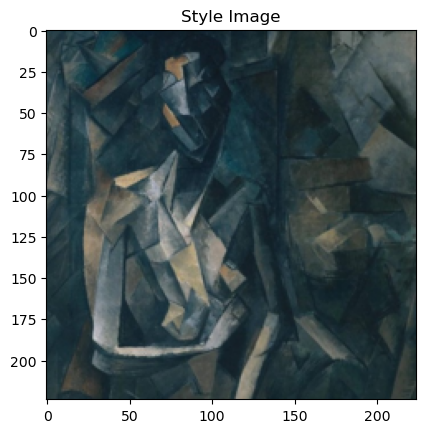

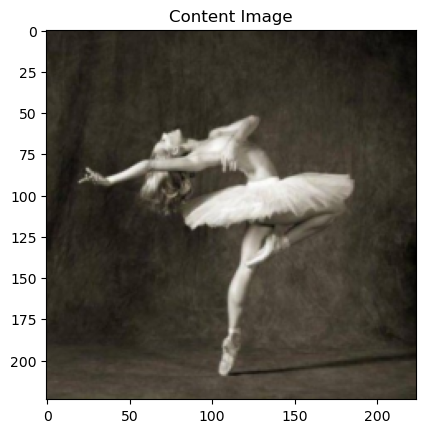

In [144]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss Functions

In [145]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style Loss

In [146]:
def gram_matrix(input):
    a, b, c, d = input.size()  

    features = input.view(a * b, c * d)  

    G = torch.mm(features, features.t()) 

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [147]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Importing the Model




In [148]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Additionally, VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
We will use them to normalize the image before sending it into the network.




In [149]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [187]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4']#,'conv_5'] #in vgg19

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization).to(device)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
    
        model.add_module(name, layer)
        model.to(device=device)
        #print(model)
        #print("************")
        if name in content_layers:
            # add content loss:
            target = model(content_img)
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img)
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
        
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    

    return model, style_losses, content_losses

Next, we select the input image. You can use a copy of the content image
or white noise.




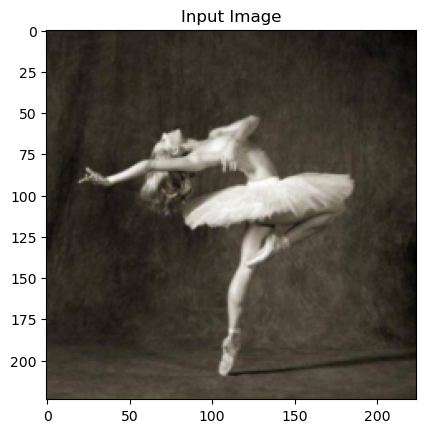

In [174]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

## Gradient Descent




In [175]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [176]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    
    print(model)
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [177]:
# reference https://stackoverflow.com/a/74231695
def flatten_model(modules):
    def flatten_list(_2d_list):
        flat_list = []
        # Iterate through the outer list
        for element in _2d_list:
            if type(element) is list:
                # If the element is of type list, iterate through the sublist
                for item in element:
                    flat_list.append(item)
            else:
                flat_list.append(element)
        return flat_list

    ret = []
    try:
        for _, n in modules:
            ret.append(loopthrough(n))
    except:
        try:
            if str(modules._modules.items()) == "odict_items([])":
                ret.append(modules)
            else:
                for _, n in modules._modules.items():
                    ret.append(loopthrough(n))
        except:
            ret.append(modules)
    return flatten_list(ret)



module_list =[module for module in resnet.modules()] # this is needed
flatted_list= flatten_model(module_list)
model1 = nn.Sequential()

for count, value in enumerate(flatted_list):
    if isinstance(value, (nn.Conv2d,nn.AvgPool2d,nn.BatchNorm2d,nn.MaxPool2d, nn.ReLU)):
        model1.add_module(str(count), value)
        

Building the style transfer model..
Optimizing..
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (style_loss_1): StyleLoss()
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU()
  (pool_1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (style_loss_2): StyleLoss()
  (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (style_loss_3): StyleLoss()
  (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


run [50]:
Style Loss : 9.232912 Content Loss: 2.857676

run [100]:
Style Loss : 2.385140 Content Loss: 2.901842

run [150]:
Style Loss : 1.111737 Content Loss: 2.883074

run [200]:
Style Loss : 0.667983 Content Loss: 2.847566

run [250]:
Style Loss : 0.439650 Content Loss: 2.804864

run [300]:
Style Loss : 0.325209 Content Loss: 2.764554



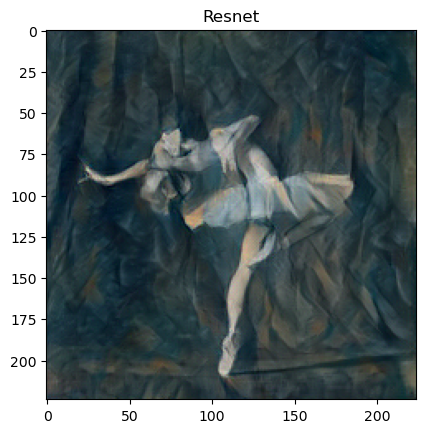

In [188]:
output = run_style_transfer(model1, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Resnet')

plt.ioff()
plt.show()